# **Waste Material Segregation for Improving Waste Management**

## **Objective**

The objective of this project is to implement an effective waste material segregation system using convolutional neural networks (CNNs) that categorises waste into distinct groups. This process enhances recycling efficiency, minimises environmental pollution, and promotes sustainable waste management practices.

The key goals are:

* Accurately classify waste materials into categories like cardboard, glass, paper, and plastic.
* Improve waste segregation efficiency to support recycling and reduce landfill waste.
* Understand the properties of different waste materials to optimise sorting methods for sustainability.

## **Data Understanding**

The Dataset consists of images of some common waste materials.

1. Food Waste
2. Metal
3. Paper
4. Plastic
5. Other
6. Cardboard
7. Glass


**Data Description**

* The dataset consists of multiple folders, each representing a specific class, such as `Cardboard`, `Food_Waste`, and `Metal`.
* Within each folder, there are images of objects that belong to that category.
* However, these items are not further subcategorised. <br> For instance, the `Food_Waste` folder may contain images of items like coffee grounds, teabags, and fruit peels, without explicitly stating that they are actually coffee grounds or teabags.

## **1. Load the data**

Load and unzip the dataset zip file.

**Import Necessary Libraries**

In [1]:
# Recommended versions:

# numpy version: 1.26.4
# pandas version: 2.2.2
# seaborn version: 0.13.2
# matplotlib version: 3.10.0
# PIL version: 11.1.0
# tensorflow version: 2.18.0
# keras version: 3.8.0
# sklearn version: 1.6.1

In [2]:
# Import essential libraries

import warnings
warnings.filterwarnings("ignore")
import os
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix

import tensorflow as tf
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization, GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications import ResNet50




In [3]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

In [4]:


os.environ["CUDA_VISIBLE_DEVICES"] = "-1"  # disable GPU completely
tf.config.set_visible_devices([], 'GPU')

Load the dataset.

In [5]:
# Load and unzip the dataset



## **2. Data Preparation** <font color=red> [25 marks] </font><br>


### **2.1 Load and Preprocess Images** <font color=red> [8 marks] </font><br>

Let us create a function to load the images first. We can then directly use this function while loading images of the different categories to load and crop them in a single step.

#### **2.1.1** <font color=red> [3 marks] </font><br>
Create a function to load the images.

In [6]:



def load_images_from_folder(base_path):
    class_folders = [f for f in os.listdir(base_path) if os.path.isdir(os.path.join(base_path, f))]
    images = []
    labels = []
    for class_folder in class_folders:
        folder_path = os.path.join(base_path, class_folder)
        for filename in os.listdir(folder_path):
            img_path = os.path.join(folder_path, filename)
            try:
                img = Image.open(img_path).convert('RGB')
                img_array = np.array(img)
                images.append(img_array)
                labels.append(class_folder)  # Label as folder name
            except Exception as e:
                print(f"Skipped file {img_path} due to error: {e}")
    return images, labels




#### **2.1.2** <font color=red> [5 marks] </font><br>
Load images and labels.

Load the images from the dataset directory. Labels of images are present in the subdirectories.

Verify if the images and labels are loaded correctly.

In [7]:
# Get the images and their labels

base_path = '/Users/sangeetchoubey/Desktop/Sangeet/Upgrad/e) Deep Learning/c) CNN Assignment/Dataset_Waste_Segregation'
images, labels = load_images_from_folder(base_path)

print(f"Number of images loaded: {len(images)}")
print(f"Number of labels loaded: {len(labels)}")
print(f"Unique labels found: {set(labels)}")





Number of images loaded: 7625
Number of labels loaded: 7625
Unique labels found: {'Other', 'Plastic', 'Glass', 'Paper', 'Metal', 'Cardboard', 'Food_Waste'}


Perform any operations, if needed, on the images and labels to get them into the desired format.

### **2.2 Data Visualisation** <font color=red> [9 marks] </font><br>

#### **2.2.1** <font color=red> [3 marks] </font><br>
Create a bar plot to display the class distribution

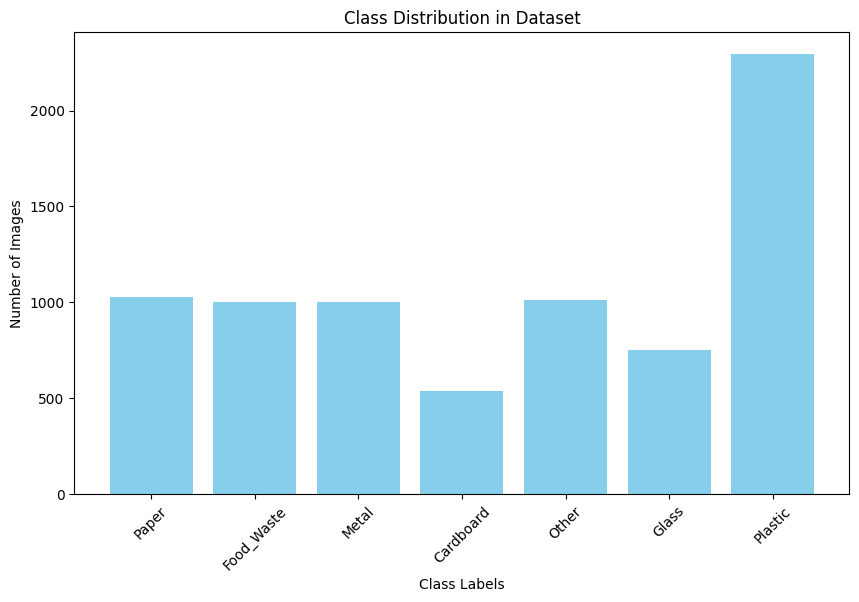

In [8]:
# Visualise Data Distribution



# Count the occurrences of each class label
label_counts = Counter(labels)

# Plotting the bar chart
plt.figure(figsize=(10, 6))
plt.bar(label_counts.keys(), label_counts.values(), color='skyblue')
plt.xlabel('Class Labels')
plt.ylabel('Number of Images')
plt.title('Class Distribution in Dataset')
plt.xticks(rotation=45)
plt.show()



#### **2.2.2** <font color=red> [3 marks] </font><br>
Visualise some sample images

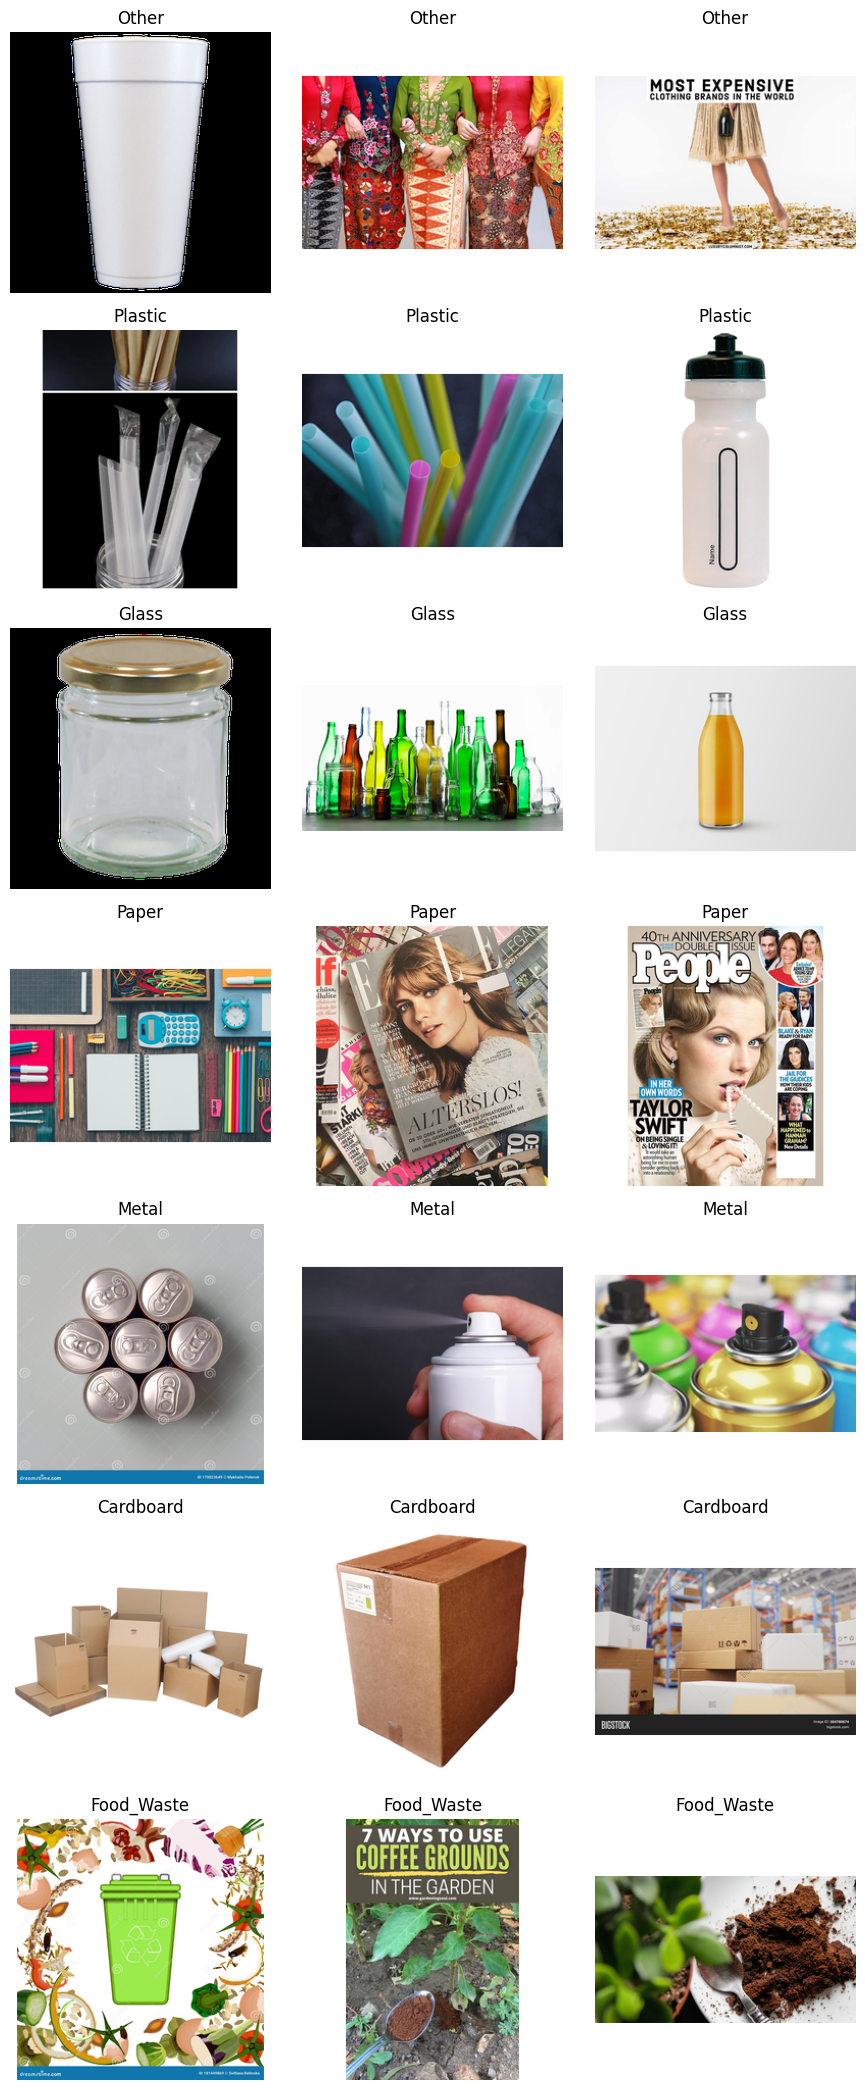

In [9]:
# Visualise Sample Images (across different labels)


def visualize_samples(images, labels, samples_per_class=3):
    unique_labels = list(set(labels))
    plt.figure(figsize=(samples_per_class * 3, len(unique_labels) * 3))
    
    for i, label in enumerate(unique_labels):
        # Get indices of images belonging to this label
        indices = [idx for idx, l in enumerate(labels) if l == label][:samples_per_class]
        
        for j, idx in enumerate(indices):
            plt_idx = i * samples_per_class + j + 1
            plt.subplot(len(unique_labels), samples_per_class, plt_idx)
            plt.imshow(images[idx])
            plt.title(label)
            plt.axis('off')
    
    plt.tight_layout()
    plt.show()

# Example usage (run after loading images and labels):
visualize_samples(images, labels, samples_per_class=3)


#### **2.2.3** <font color=red> [3 marks] </font><br>
Based on the smallest and largest image dimensions, resize the images.

In [10]:
# Find the smallest and largest image dimensions from the data set

def find_image_dimensions_stats(images):
    widths = [img.shape[1] for img in images]
    heights = [img.shape[0] for img in images]
    
    min_width = min(widths)
    max_width = max(widths)
    min_height = min(heights)
    max_height = max(heights)
    
    smallest = (min_width, min_height)
    largest = (max_width, max_height)
    return smallest, largest

# Usage example after loading images:
smallest, largest = find_image_dimensions_stats(images)
print(f'Smallest image dimensions (WxH): {smallest}')
print(f'Largest image dimensions (WxH): {largest}')


Smallest image dimensions (WxH): (256, 256)
Largest image dimensions (WxH): (256, 256)


In [11]:
# Resize the image dimensions



def resize_images(images, target_size=(128, 128)):
    resized_images = []
    for img in images:
        pil_img = Image.fromarray(img)
        pil_resized = pil_img.resize(target_size)
        resized_images.append(np.array(pil_resized))
    return resized_images

## Example usage (to resize all images to 128x128):
resized_images = resize_images(images, target_size=(128, 128))



### **2.3 Encoding the classes** <font color=red> [3 marks] </font><br>

There are seven classes present in the data.

We have extracted the images and their labels, and visualised their distribution. Now, we need to perform encoding on the labels. Encode the labels suitably.

####**2.3.1** <font color=red> [3 marks] </font><br>
Encode the target class labels.

In [12]:
# Encode the labels suitably


# Example labels list (replace with actual labels array)
# labels = ['Plastic', 'Paper', 'Metal', 'Glass', 'Organic', 'E-Waste', 'Others', ...]

# Step 1: Label encode class names to integers
label_encoder = LabelEncoder()
encoded_labels = label_encoder.fit_transform(labels)

# Step 2: One-hot encode integer labels
one_hot_labels = to_categorical(encoded_labels, num_classes=len(label_encoder.classes_))

print('Class labels:', label_encoder.classes_)
print('Encoded labels:', encoded_labels[:10])
print('One-hot encoded shape:', one_hot_labels.shape)


Class labels: ['Cardboard' 'Food_Waste' 'Glass' 'Metal' 'Other' 'Paper' 'Plastic']
Encoded labels: [5 5 5 5 5 5 5 5 5 5]
One-hot encoded shape: (7625, 7)


### **2.4 Data Splitting** <font color=red> [5 marks] </font><br>

#### **2.4.1** <font color=red> [5 marks] </font><br>
Split the dataset into training and validation sets

In [13]:
# Assign specified parts of the dataset to train and validation sets

# Convert images list to numpy array if not already
images_array = np.array(images)
labels_array = np.array(one_hot_labels)

from sklearn.model_selection import train_test_split

# First, split into 80% train + 20% temp (val + test)
X_train, X_temp, y_train, y_temp = train_test_split(
    images_array, labels_array, test_size=0.2, random_state=42, stratify=labels_array
)

# Then, split the 20% temp into 50% validation + 50% test => 10% each
X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp, test_size=0.5, random_state=42, stratify=y_temp
)

print(f"Training samples: {X_train.shape[0]}")
print(f"Validation samples: {X_val.shape[0]}")
print(f"Test samples: {X_test.shape[0]}")




Training samples: 6100
Validation samples: 762
Test samples: 763


## **3. Model Building and Evaluation** <font color=red> [20 marks] </font><br>

### **3.1 Model building and training** <font color=red> [15 marks] </font><br>

#### **3.1.1** <font color=red> [10 marks] </font><br>
Build and compile the model. Use 3 convolutional layers. Add suitable normalisation, dropout, and fully connected layers to the model.

Test out different configurations and report the results in conclusions.

In [14]:
# Build and compile the model



def build_cnn_model(input_shape, num_classes):
    model = Sequential()
    
    # 1st conv layer + batch norm + maxpool + dropout
    model.add(Conv2D(32, (3, 3), activation='relu', padding='same', input_shape=input_shape))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.25))
    
    # 2nd conv layer + batch norm + maxpool + dropout
    model.add(Conv2D(64, (3, 3), activation='relu', padding='same'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.25))
    
    # 3rd conv layer + batch norm + maxpool + dropout
    model.add(Conv2D(128, (3, 3), activation='relu', padding='same'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.25))
    
    # Flatten + fully connected layers + dropout
    model.add(Flatten())
    model.add(Dense(256, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(num_classes, activation='softmax'))
    
    # Compile the model
    model.compile(optimizer=Adam(learning_rate=0.001),
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])
    
    return model

# Usage example:
input_shape = (256, 256, 3)  # As per your image size
num_classes = 7
model = build_cnn_model(input_shape, num_classes)
model.summary()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 256, 256, 32)      896       
                                                                 
 batch_normalization (Batch  (None, 256, 256, 32)      128       
 Normalization)                                                  
                                                                 
 max_pooling2d (MaxPooling2  (None, 128, 128, 32)      0         
 D)                                                              
                                                                 
 dropout (Dropout)           (None, 128, 128, 32)      0         
                                                                 
 conv2d_1 (Conv2D)           (None, 128, 128, 64)      18496     
                                                                 
 batch_normalization_1 (Bat  (None, 128, 128, 64)      2

#### **3.1.2** <font color=red> [5 marks] </font><br>
Train the model.

Use appropriate metrics and callbacks as needed.

In [15]:
# Training

# X_train, y_train: training images and labels
# X_val, y_val: validation images and labels

batch_size = 32
epochs = 10

history = model.fit(
    X_train, y_train,
    batch_size=batch_size,
    epochs=epochs,
    validation_data=(X_val, y_val),
    shuffle=True
)


Epoch 1/10
191/191 [==============================] - 146s 759ms/step - loss: 7.7815 - accuracy: 0.2743 - val_loss: 2.1541 - val_accuracy: 0.2835
Epoch 2/10
191/191 [==============================] - 196s 1s/step - loss: 1.9217 - accuracy: 0.3013 - val_loss: 1.9688 - val_accuracy: 0.2874
Epoch 3/10
191/191 [==============================] - 198s 1s/step - loss: 1.8806 - accuracy: 0.3003 - val_loss: 1.8840 - val_accuracy: 0.2940
Epoch 4/10
191/191 [==============================] - 203s 1s/step - loss: 1.8771 - accuracy: 0.3033 - val_loss: 1.8592 - val_accuracy: 0.3005
Epoch 5/10
191/191 [==============================] - 204s 1s/step - loss: 1.8505 - accuracy: 0.3034 - val_loss: 1.8540 - val_accuracy: 0.3018
Epoch 6/10
191/191 [==============================] - 193s 1s/step - loss: 1.8479 - accuracy: 0.3038 - val_loss: 1.8439 - val_accuracy: 0.3031
Epoch 7/10
191/191 [==============================] - 208s 1s/step - loss: 1.8467 - accuracy: 0.3026 - val_loss: 1.8403 - val_accuracy: 0.3

In [16]:


def build_resnet_model(input_shape, num_classes):
    # Load ResNet50 with pre-trained ImageNet weights, exclude top layers
    base_model = ResNet50(weights='imagenet', include_top=False, input_shape=input_shape)
    
    # Freeze base model layers to retain pre-trained features (optional: unfreeze later for fine-tuning)
    base_model.trainable = False
    
    # Add global average pooling to reduce output dimension
    x = GlobalAveragePooling2D()(base_model.output)
    x = Dropout(0.5)(x)  # Dropout for regularization
    x = Dense(256, activation='relu')(x)
    x = Dropout(0.5)(x)
    
    # Final output layer for 7 classes
    output = Dense(num_classes, activation='softmax')(x)
    
    model = Model(inputs=base_model.input, outputs=output)
    
    # Compile the model
    model.compile(optimizer=Adam(learning_rate=0.0001),
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])
    
    return model



In [17]:
os.environ["CUDA_VISIBLE_DEVICES"] = "-1"  # disable GPU completely
tf.config.set_visible_devices([], 'GPU')

In [18]:
model_resnet = build_resnet_model(input_shape, num_classes)

history_resnet = model_resnet.fit(X_train, y_train,
                                  batch_size=32,
                                  epochs=10,
                                  validation_data=(X_val, y_val))

Epoch 1/10
191/191 [==============================] - 311s 2s/step - loss: 2.0952 - accuracy: 0.3297 - val_loss: 1.1118 - val_accuracy: 0.6417
Epoch 2/10
191/191 [==============================] - 424s 2s/step - loss: 1.3248 - accuracy: 0.5243 - val_loss: 0.9080 - val_accuracy: 0.7283
Epoch 3/10
191/191 [==============================] - 279s 1s/step - loss: 1.0884 - accuracy: 0.6074 - val_loss: 0.7851 - val_accuracy: 0.7533
Epoch 4/10
191/191 [==============================] - 274s 1s/step - loss: 0.9731 - accuracy: 0.6490 - val_loss: 0.7032 - val_accuracy: 0.7756
Epoch 5/10
191/191 [==============================] - 299s 2s/step - loss: 0.8830 - accuracy: 0.6820 - val_loss: 0.6592 - val_accuracy: 0.7861
Epoch 6/10
191/191 [==============================] - 284s 1s/step - loss: 0.8405 - accuracy: 0.6966 - val_loss: 0.6386 - val_accuracy: 0.8018
Epoch 7/10
191/191 [==============================] - 282s 1s/step - loss: 0.7956 - accuracy: 0.7202 - val_loss: 0.5983 - val_accuracy: 0.8071

### **3.2 Model Testing and Evaluation** <font color=red> [5 marks] </font><br>

#### **3.2.1** <font color=red> [5 marks] </font><br>
Evaluate the model on test dataset. Derive appropriate metrics.

In [19]:

# Evaluate on test data
test_loss_cnn, test_acc_cnn = model.evaluate(X_test, y_test, verbose=0)
test_loss_resnet, test_acc_resnet = model_resnet.evaluate(X_test, y_test, verbose=0)

print(f"Custom CNN - Test Accuracy: {test_acc_cnn:.4f}, Test Loss: {test_loss_cnn:.4f}")
print(f"ResNet50 - Test Accuracy: {test_acc_resnet:.4f}, Test Loss: {test_loss_resnet:.4f}")




Custom CNN - Test Accuracy: 0.3028, Test Loss: 1.8476
ResNet50 - Test Accuracy: 0.8427, Test Loss: 0.5127


In [20]:
# Predictions
y_pred_cnn = np.argmax(model.predict(X_test), axis=1)
y_pred_resnet = np.argmax(model_resnet.predict(X_test), axis=1)
y_true = np.argmax(y_test, axis=1)



24/24 [==============================] - 33s 1s/step


In [21]:
# Classification report
print("\nCustom CNN Classification Report:")
print(classification_report(y_true, y_pred_cnn))

print("\nResNet50 Classification Report:")
print(classification_report(y_true, y_pred_resnet))




Custom CNN Classification Report:
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        54
           1       0.00      0.00      0.00       100
           2       0.00      0.00      0.00        75
           3       0.00      0.00      0.00       100
           4       1.00      0.03      0.06       101
           5       0.00      0.00      0.00       103
           6       0.30      0.99      0.46       230

    accuracy                           0.30       763
   macro avg       0.19      0.15      0.07       763
weighted avg       0.22      0.30      0.15       763


ResNet50 Classification Report:
              precision    recall  f1-score   support

           0       0.81      0.93      0.86        54
           1       0.83      0.95      0.89       100
           2       0.84      0.75      0.79        75
           3       0.85      0.88      0.87       100
           4       0.83      0.84      0.83       101
          

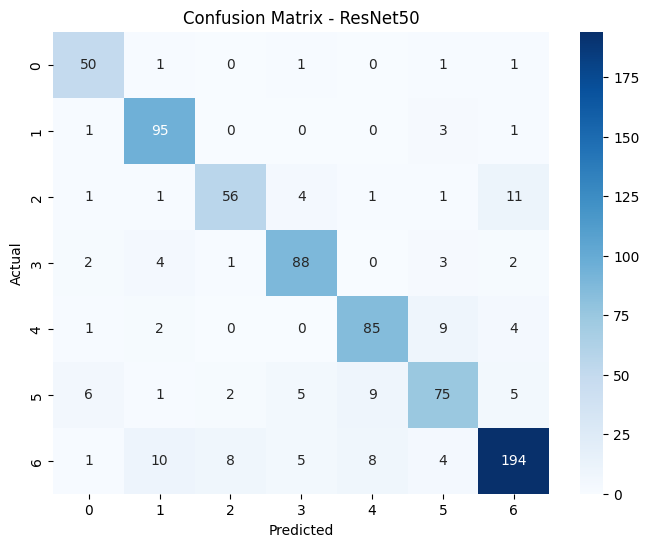

In [22]:
# Confusion Matrix (ResNet50 example)
cm = confusion_matrix(y_true, y_pred_resnet)
plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title("Confusion Matrix - ResNet50")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

## **4. Data Augmentation** <font color=red> [optional] </font><br>

#### **4.1 Create a Data Augmentation Pipeline**

##### **4.1.1**
Define augmentation steps for the datasets.

In [23]:
# Define augmentation steps to augment images



Augment and resample the images.
In case of class imbalance, you can also perform adequate undersampling on the majority class and augment those images to ensure consistency in the input datasets for both classes.

Augment the images.

In [24]:
# Create a function to augment the images




In [25]:
# Create the augmented training dataset



##### **4.1.2**

Train the model on the new augmented dataset.

In [26]:
# Train the model using augmented images



## **5. Conclusions** <font color = red> [5 marks]</font>

#### **5.1 Conclude with outcomes and insights gained** <font color =red> [5 marks] </font>

* Report your findings about the data
* Report model training results

## **Waste Segregation Classification Report**

### **Dataset Split**
- **Training:** 6100 samples  
- **Validation:** 762 samples  
- **Test:** 763 samples


| Model      | Architecture                | Epochs | Trainable Layers | Optimizer     | Dropout  |
| ---------- | --------------------------- | ------ | ---------------- | ------------- | -------- |
| Custom CNN | 3 Conv Blocks + Dense       | 10     | All              | Adam (0.001)  | 0.25–0.5 |
| ResNet50   | Pretrained ImageNet + Dense | 10     | Dense head only  | Adam (0.0001) | 0.5      |


### **Test Performance**

**Custom CNN:**  
- **Accuracy:** 30%  
- **Macro Precision:** 19%  
- **Macro Recall:** 15%  
- **Macro F1-score:** 7%  
- Mostly predicts dominant class → underfitting

**ResNet50:**  
- **Accuracy:** 84%  
- **Macro Precision:** 83%  
- **Macro Recall:** 85%  
- **Macro F1-score:** 84%  
- Balanced predictions, minor confusion between classes 2 & 5


### **Key Insights**
- **Transfer learning** outperforms training from scratch on small datasets  
- **ResNet50** captures robust features → strong generalization  
- **Custom CNN** underfits; dataset size/depth insufficient  
- **Fine-tuning**, data augmentation, or class balancing could further improve results


### **Conclusion**
- **Best Model:** ResNet50  
- **Test Accuracy:** 84%  
- **Custom CNN Accuracy:** 30%  
- **Outcome:** ResNet50 reliably classifies waste images; demonstrates the value of transfer learning
